In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
## To download vader files
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import spearmanr, pearsonr

<h3> Raw Data </h3>

In [258]:
drugs_com_raw = pd.read_csv('drugs_com.csv')
drugs_com_raw.shape

(215063, 7)

<h3> After preprocessing </h3>

In [259]:
drugs_com = pd.read_csv('drugs_com_conditions_transformed.csv',parse_dates=['date'])
drugs_com.shape

(212106, 7)

In [3]:
drugs_com.head()

,user_id,drug,condition,review,rating,date,useful_count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


<h1> Exploratory Data Analysis </h1> 

In [4]:
len(drugs_com.drug.unique())

3650

In [5]:
len(drugs_com.condition.unique())

829

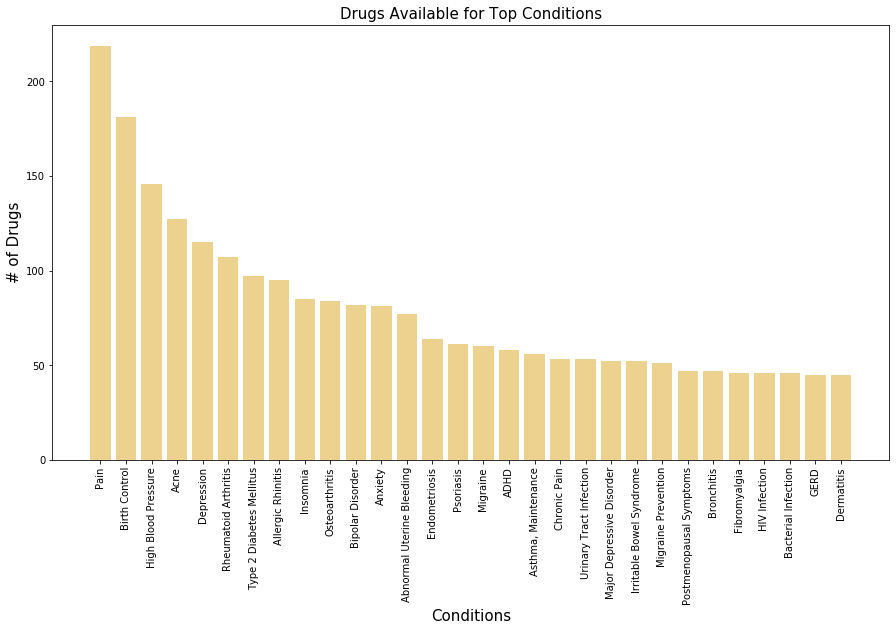

In [171]:
# Number of drugs available for top conditions
df = drugs_com.groupby(['condition'])['drug'].nunique().sort_values(ascending = False).reset_index().head(30)
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['condition'],height = df['drug'],color = 'goldenrod',alpha=0.5)
plt.xticks(rotation=90)
plt.title('Drugs Available for Top Conditions', fontsize = 15)
plt.xlabel('Conditions', fontsize = 15)
plt.ylabel('# of Drugs', fontsize = 15)
plt.show()

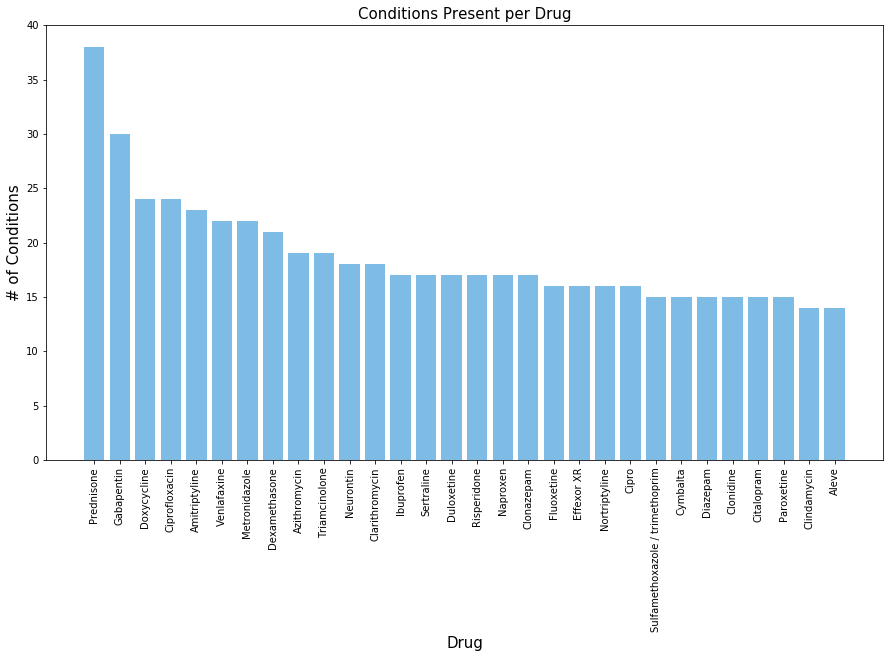

In [175]:
# Number of conditions present per drug
df = drugs_com.groupby(['drug'])['condition'].nunique().sort_values(ascending = False).reset_index().head(30)
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['drug'],height = df['condition'],color = '#007acc',alpha=0.5)

plt.title('Conditions Present per Drug', fontsize = 15)
plt.xlabel('Drug', fontsize = 15)
plt.ylabel('# of Conditions', fontsize = 15)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,45,5))
plt.show()

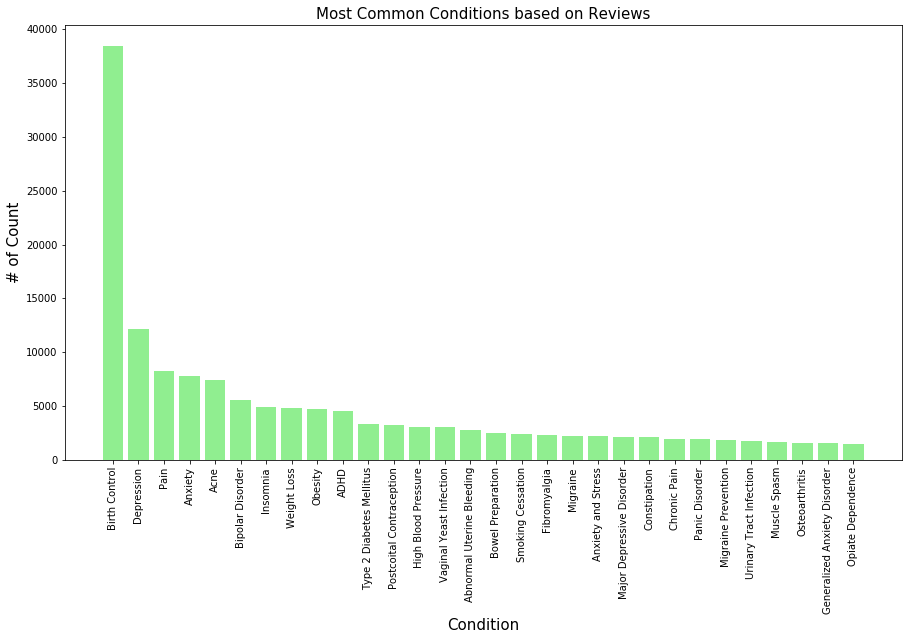

In [177]:
# Most Common Conditions based on Reviews
df = drugs_com['condition'].value_counts().head(30).reset_index()
df.columns = ['condition','count']
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['condition'],height = df['count'],color = 'lightgreen')
plt.xticks(rotation=90)
plt.title('Most Common Conditions based on Reviews', fontsize = 15)
plt.xlabel('Condition', fontsize = 15)
plt.ylabel('# of Count', fontsize = 15)
plt.show()

In [189]:
# Converting the date into datetime format
drugs_com['date'] = pd.to_datetime(drugs_com['date'], errors = 'coerce')

# Extracting year, month and day from date
drugs_com['year'] = drugs_com['date'].dt.year

drugs_com['month'] = drugs_com['date'].dt.month

drugs_com['day'] = drugs_com['date'].dt.day

drugs_com.head()

,user_id,drug,condition,review,rating,date,useful_count,year,month,day
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27,2012,5,20
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192,2010,4,27
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17,2009,12,14
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10,2015,11,3
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37,2016,11,27


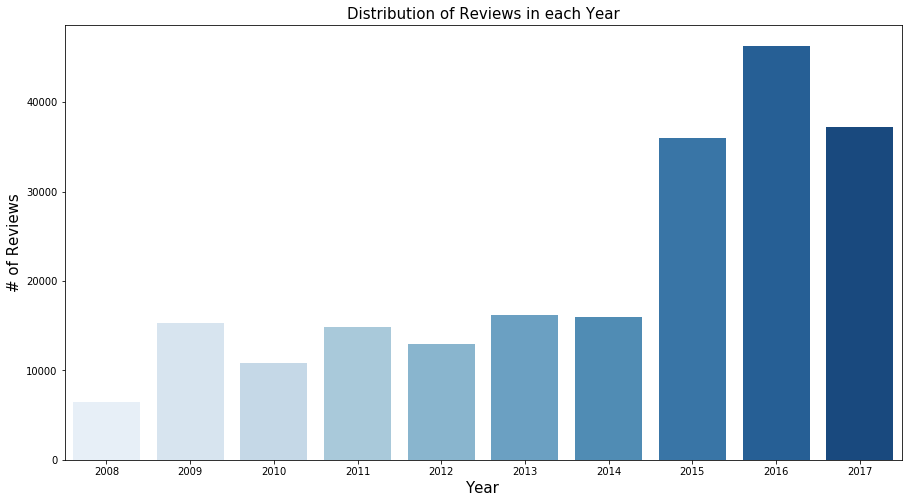

In [205]:
# Distribution of reviews in each year
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(drugs_com['year'], palette ='Blues')
plt.title('Distribution of Reviews in each Year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('# of Reviews', fontsize = 15)
plt.show()

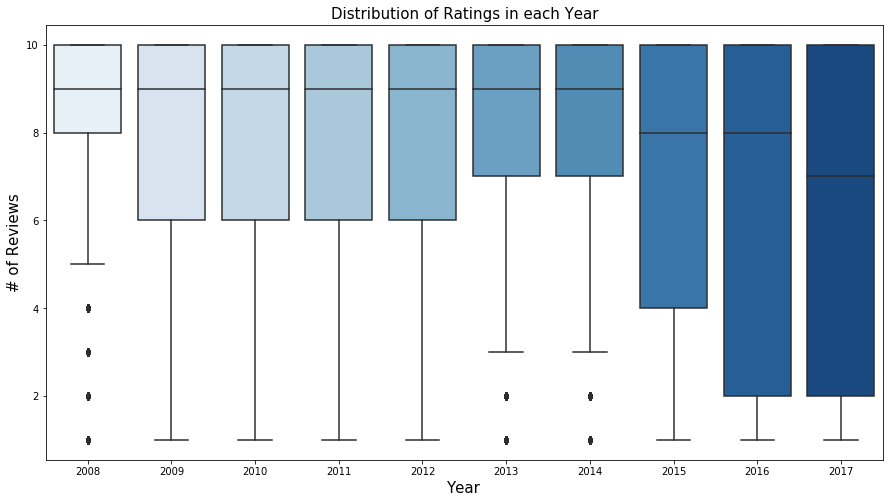

In [190]:
# Distribution of ratings in each year
plt.rcParams['figure.figsize'] = (15, 8)
sns.boxplot(x = drugs_com['year'], y = drugs_com['rating'], palette ='Blues')
plt.title('Distribution of Ratings in each Year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('# of Reviews', fontsize = 15)
plt.show()

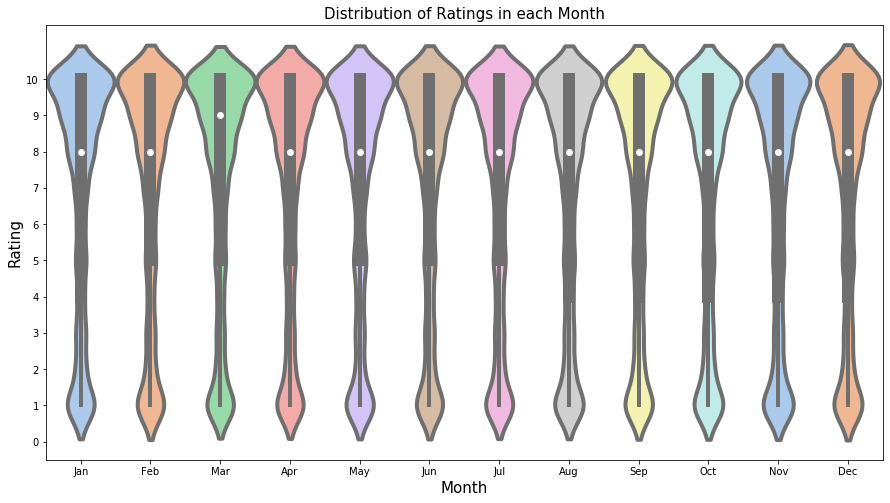

In [195]:
# Distribution of ratings in each month
plt.rcParams['figure.figsize'] = (15, 8)
sns.violinplot(x = drugs_com['month'], y = drugs_com['rating'], palette ='pastel',linewidth=4,width=1)
plt.title('Distribution of Ratings in each Month', fontsize = 15)
plt.yticks(np.arange(0,11))
plt.xticks(np.arange(12),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Rating', fontsize = 15)
plt.show()

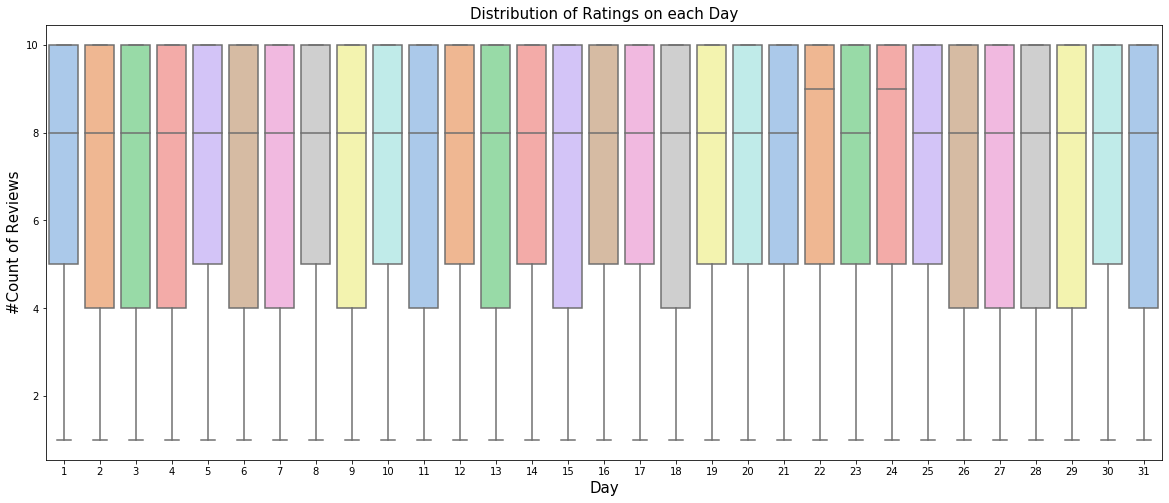

In [196]:
# Distribution of ratings on each day
plt.rcParams['figure.figsize'] = (20,8)
sns.boxplot(x = drugs_com['day'], y = drugs_com['rating'], palette ='pastel')
plt.title('Distribution of Ratings on each Day', fontsize = 15)
plt.xlabel('Day', fontsize = 15)
plt.ylabel('#Count of Reviews', fontsize = 15)
plt.show()

<h1>Sentiment Analysis</h1>

<h3> Sentiment analysis on user reviews. </h3>

In [264]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

<h3> Filtering missing reviews</h3>

In [265]:
print("Before removing missing reviews: ",drugs_com.shape)
drugs_com_df = drugs_com[drugs_com['review'] != " "]
print("After removing missing reviews: ",drugs_com_df.shape)

Before removing missing reviews:  (212106, 7)
After removing missing reviews:  (212106, 7)


In [248]:
# Calculate sentiment polarity on each review
drugs_com['sentiment'] = drugs_com['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

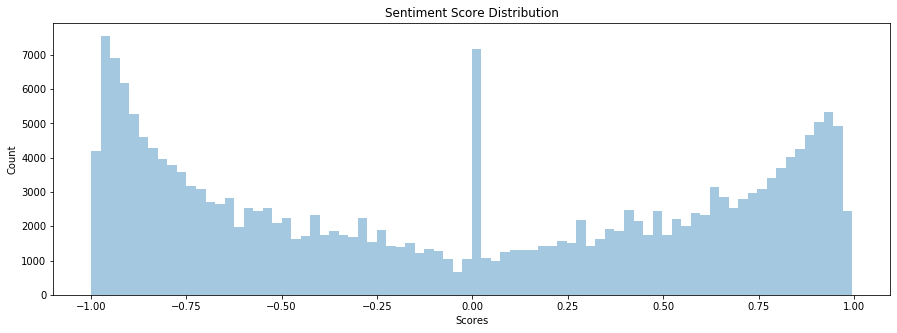

In [233]:
plt.figure(figsize=(15,5))
ax = sns.distplot(drugs_com['sentiment'],bins=80,kde=False)
plt.title('Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count');

<h1> Statistical Analysis </h1>

<h3> Univariate Analysis (Ex: Pie chart) 
    - Distribution of review ratings </h3>

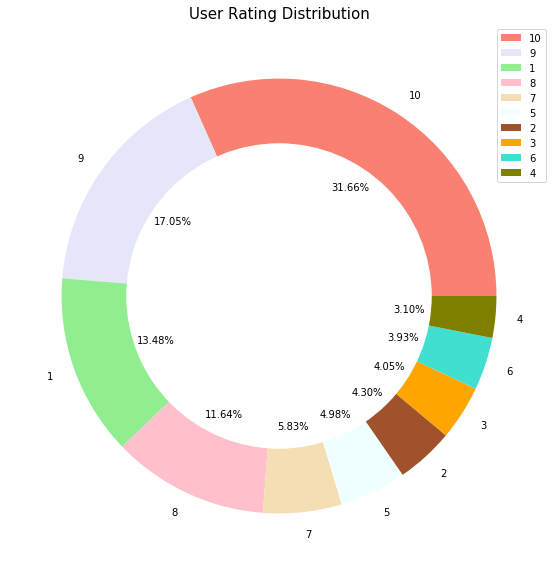

In [187]:
# Frequency of each rating
df = drugs_com['rating'].value_counts().reset_index()

# Converting float rating values to int
df.columns = ['rating','count']
df = df.astype({'rating':'int'})

# Plotting user rating distribution
size = df['count']
colors = ['salmon','lavender','lightgreen','pink','wheat','azure','sienna','orange','turquoise','olive']
labels = df['rating']

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size,colors = colors,labels = labels, autopct = '%.2f%%')
plt.title('User Rating Distribution', fontsize = 15)
plt.legend()
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.show()

<h3> Bivariate analysis (Ex: scatter plot, joint plots) is used to show relationship between two variables.</h3>
<h3> 1. Joint plot of Sentiment Score vs Rating </h3>

Joint plot of Sentiment Score vs Rating


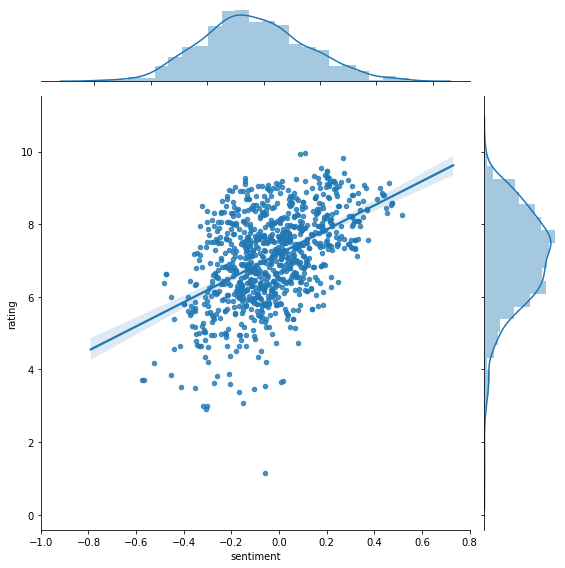

In [253]:
# Joint plot of sentiment score vs rating

reviews_per_drug = drugs_com.groupby(['drug']).agg({
    'user_id': pd.Series.nunique
})

drugs_sentiment = drugs_com.groupby(['drug'])

drugs_sentiment = drugs_sentiment.agg({
    'sentiment': np.mean, 
    'rating': np.mean,
    'user_id': pd.Series.nunique
})

drugs_sentiment = drugs_sentiment[drugs_sentiment['user_id'] > reviews_per_drug.quantile(q=0.75)[0]]

sns.jointplot(x= 'sentiment', y= 'rating', data=drugs_sentiment, kind='reg', height=8, scatter_kws={'s': 20})
print('Joint plot of Sentiment Score vs Rating')
plt.xticks(np.arange(-1,1,0.2))
plt.show()

<h3> 2. Average Useful Count vs Rating </h3>

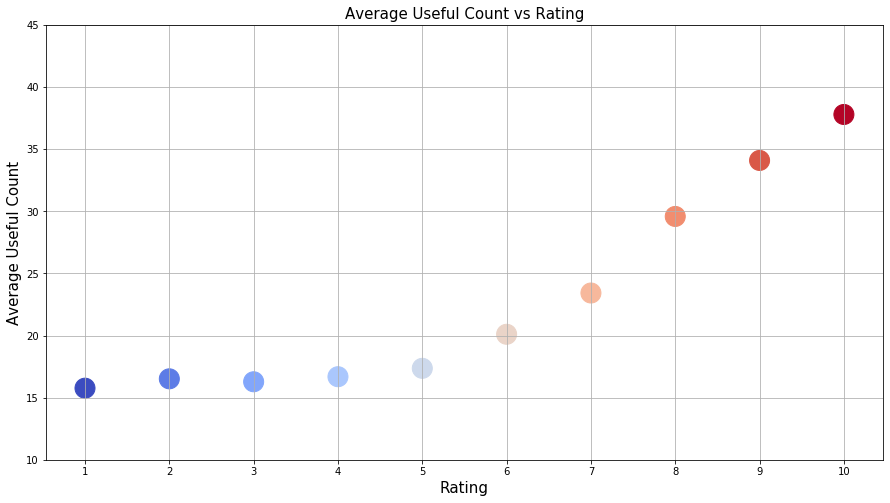

In [268]:
#Scatter plot of average useful_count vs rating
avg_useful_count_list = []

ratings = range(1, 11)

for i in ratings:
    avg_useful_count_list.append([i, np.sum(drugs_com[drugs_com['rating'] == i].useful_count) / np.sum([drugs_com['rating'] == i])])
    
count_arr = np.asarray(avg_useful_count_list)

plt.rcParams['figure.figsize'] = (15, 8)
plt.scatter(count_arr[:, 0], count_arr[:, 1], c=count_arr[:, 0], cmap = 'coolwarm', s=400)
plt.title('Average Useful Count vs Rating',fontsize = 15)
plt.xlabel('Rating',fontsize = 15)
plt.ylabel('Average Useful Count',fontsize = 15)
plt.xticks(np.arange(1,11))
plt.yticks(np.arange(10,50,5))
plt.grid()
plt.show()

<h3> Correlation Coefficients (Between Sentiment Score and Rating) </h3>

In [245]:
# Spearman correlation between sentiment and rating
spearmanr(drugs_sentiment['sentiment'], drugs_sentiment['rating'])

SpearmanrResult(correlation=0.4493859187727522, pvalue=4.315997901674725e-46)

In [246]:
# Pearson correlation between sentiment and rating
pearsonr(drugs_sentiment['sentiment'], drugs_sentiment['rating'])

(0.4818515548207811, 1.119700549545761e-53)